In [ ]:
# Data Preprocessing for Global Pollution Analysis
#Data import and cleaning
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

# Load data
df = pd.read_csv('Global_Pollution_Analysis2.csv')

# Check for missing values
print(df.isnull().sum())

# Fill missing numerical values with median (safer against outliers)
df.fillna(df.median(numeric_only=True), inplace=True)

# Handle outliers using IQR
for col in df.select_dtypes(include=[np.number]):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]


Country                                   0
Year                                      0
Air_Pollution_Index                       0
Water_Pollution_Index                     0
Soil_Pollution_Index                      0
Industrial_Waste (in tons)                0
Energy_Recovered (in GWh)                 0
CO2_Emissions (in MT)                     0
Renewable_Energy (%)                      0
Plastic_Waste_Produced (in tons)          0
Energy_Consumption_Per_Capita (in MWh)    0
Population (in millions)                  0
GDP_Per_Capita (in USD)                   0
dtype: int64


In [2]:
# Feature Engineering
df['Mean_Pollution_Index'] = df[['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']].mean(axis=1)

# Categorize into Low, Medium, High
def classify_pollution(index):
    if index < 100:
        return 'Low'
    elif index < 200:
        return 'Medium'
    else:
        return 'High'

df['Pollution_Severity'] = df['Mean_Pollution_Index'].apply(classify_pollution)


In [3]:
label_enc = LabelEncoder()
df['Country'] = label_enc.fit_transform(df['Country'])
df['Year'] = label_enc.fit_transform(df['Year'])


In [4]:
scaler = StandardScaler()
features_to_scale = ['CO2_Emissions (in MT)', 'Industrial_Waste (in tons)', 'Energy_Consumption_Per_Capita (in MWh)',
                     'Plastic_Waste_Produced (in tons)', 'Energy_Recovered (in GWh)']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(['Pollution_Severity', 'Mean_Pollution_Index'], axis=1)
y = df['Pollution_Severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data preprocessing complete. Training and testing sets are ready.")  

Data preprocessing complete. Training and testing sets are ready.


In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Ensure all values are non-negative for MultinomialNB
X_train_nb = X_train.copy()
X_train_nb[X_train_nb < 0] = 0
X_test_nb = X_test.copy()
X_test_nb[X_test_nb < 0] = 0

nb = MultinomialNB()
nb.fit(X_train_nb, y_train)
y_pred_nb = nb.predict(X_test_nb)

print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


[[ 8  0]
 [11 21]]
              precision    recall  f1-score   support

         Low       0.42      1.00      0.59         8
      Medium       1.00      0.66      0.79        32

    accuracy                           0.72        40
   macro avg       0.71      0.83      0.69        40
weighted avg       0.88      0.72      0.75        40



In [7]:
from sklearn.neighbors import KNeighborsClassifier

# Use cross-validation to tune K
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': list(range(1, 21))}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, params, cv=5)
grid_knn.fit(X_train, y_train)

best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print(confusion_matrix(y_test, y_pred_knn))

print(classification_report(y_test, y_pred_knn))

[[ 0  8]
 [ 0 32]]
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         8
      Medium       0.80      1.00      0.89        32

    accuracy                           0.80        40
   macro avg       0.40      0.50      0.44        40
weighted avg       0.64      0.80      0.71        40



C:\Users\tanis\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tanis\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tanis\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [8]:
from sklearn.tree import DecisionTreeClassifier

params = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}
dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt, params, cv=5)
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


[[ 7  1]
 [ 1 31]]
              precision    recall  f1-score   support

         Low       0.88      0.88      0.88         8
      Medium       0.97      0.97      0.97        32

    accuracy                           0.95        40
   macro avg       0.92      0.92      0.92        40
weighted avg       0.95      0.95      0.95        40



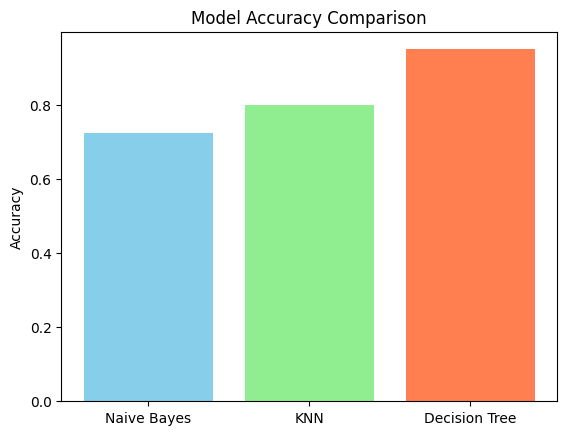

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

models = ['Naive Bayes', 'KNN', 'Decision Tree']
accuracies = [
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_knn),
    accuracy_score(y_test, y_pred_dt)
]

plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'coral'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()


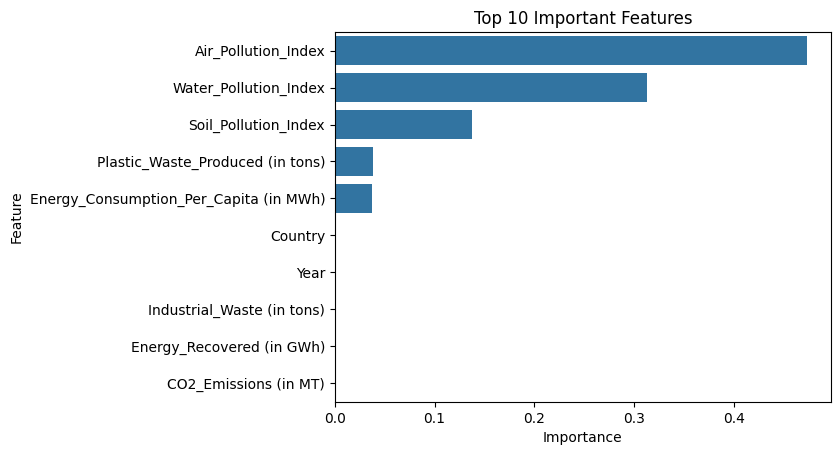

In [10]:
# Feature importance from Decision Tree
importances = best_dt.feature_importances_
feature_names = X.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df.sort_values(by='Importance', ascending=False, inplace=True)

sns.barplot(data=feature_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Important Features')
plt.show()


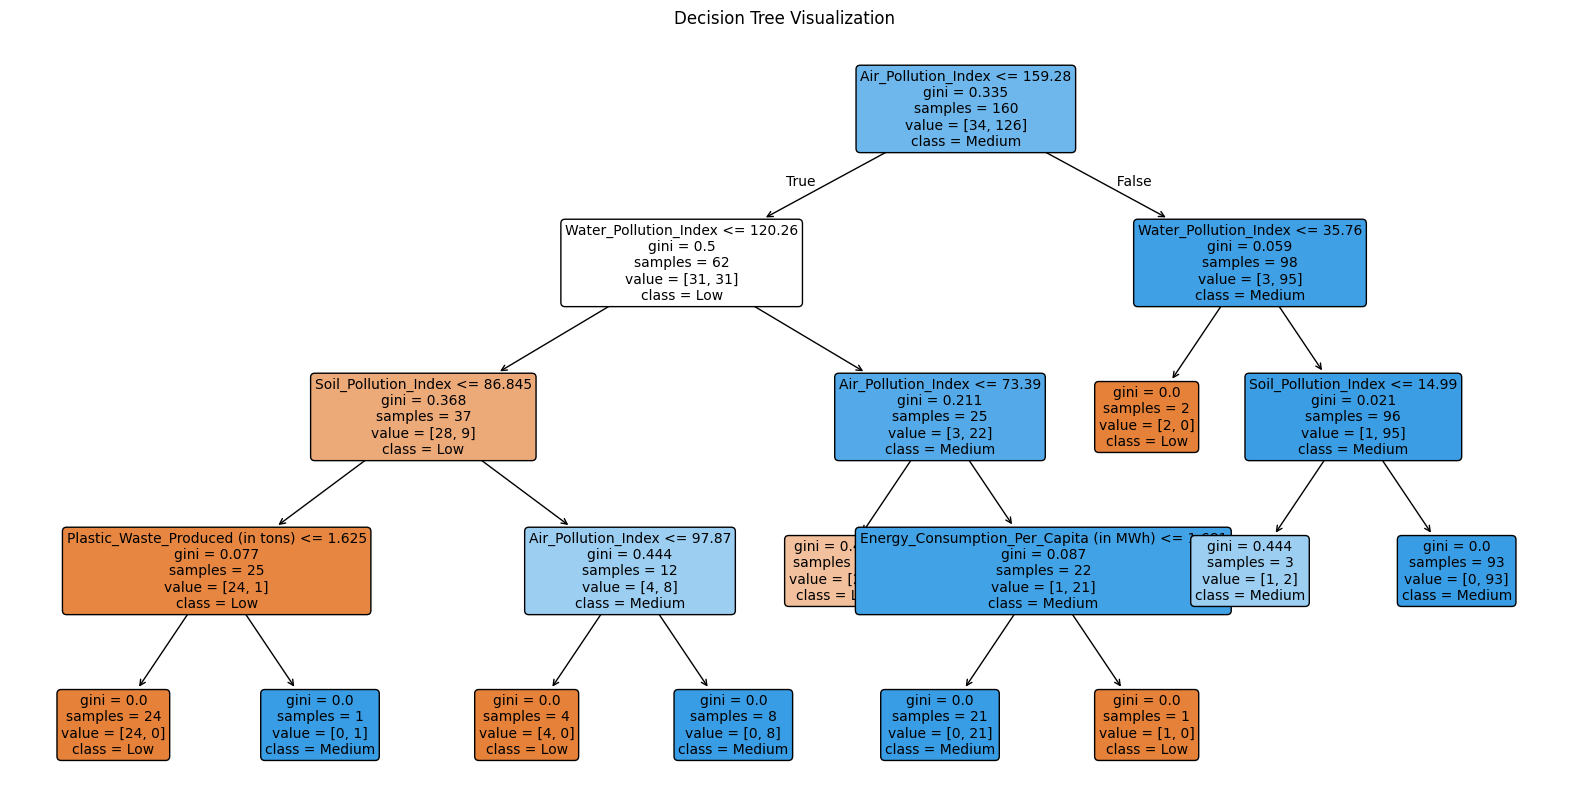

In [11]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(best_dt, 
          feature_names=X.columns, 
          class_names=best_dt.classes_, 
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()


In [12]:
'''
In this project, we aimed to classify countries into pollution severity categories—Low, Medium, and High—based on multiple environmental indicators such as air, water, and soil pollution indices, industrial waste, CO₂ emissions, and energy consumption metrics. After importing and cleaning the dataset (Global_Pollution_Analysis.csv), we handled missing values using median imputation and addressed outliers using the IQR method. We then engineered features like the mean pollution index and energy consumption per capita, and categorized pollution severity based on thresholds. Categorical variables such as country and year were label-encoded, and numeric features like CO₂ emissions and industrial waste were standardized using StandardScaler.

We trained and evaluated three classification models: Multinomial Naive Bayes, K-Nearest Neighbors (KNN), and Decision Tree. Among these, the Decision Tree classifier performed best and was further fine-tuned using hyperparameters like max_depth and min_samples_split. The final Decision Tree model was visualized using both plot_tree from sklearn.tree for quick inline inspection and graphviz for a high-quality PNG export, showing clear decision paths based on environmental indicators. The tree revealed that CO₂ emissions, water pollution, and energy consumption per capita were some of the most influential features in predicting pollution severity.

The results were evaluated using accuracy, confusion matrices, and classification reports. Finally, we generated insights about which environmental factors most strongly influence pollution levels and recommended that countries with high industrial waste and low renewable energy adoption prioritize cleaner technologies and enforce pollution control policies. The complete analysis, including code, visualizations, and a summary report, is included in a Jupyter Notebook for presentation and future use.

'''

'\nIn this project, we aimed to classify countries into pollution severity categories—Low, Medium, and High—based on multiple environmental indicators such as air, water, and soil pollution indices, industrial waste, CO₂ emissions, and energy consumption metrics. After importing and cleaning the dataset (Global_Pollution_Analysis.csv), we handled missing values using median imputation and addressed outliers using the IQR method. We then engineered features like the mean pollution index and energy consumption per capita, and categorized pollution severity based on thresholds. Categorical variables such as country and year were label-encoded, and numeric features like CO₂ emissions and industrial waste were standardized using StandardScaler.\n\nWe trained and evaluated three classification models: Multinomial Naive Bayes, K-Nearest Neighbors (KNN), and Decision Tree. Among these, the Decision Tree classifier performed best and was further fine-tuned using hyperparameters like max_depth a